In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import datasets
match = pd.read_csv('datasets/dota-2-matches/match.csv')
player_time = pd.read_csv('datasets/dota-2-matches/player_time.csv')

**player_time**: Contains last hits, experience, and gold sampled at one minute interval for all players in all matches. The column names indicate the player_slot. For instance `xp_t_1` indicates that this column has experience sums for the player in slot one.

In [3]:
player_time.head()

,match_id,times,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,...,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,60,409,0,63,142,1,186,168,0,...,62,345,6,351,100,0,77,613,1,125
2,0,120,546,0,283,622,4,645,330,0,...,543,684,12,805,200,0,210,815,5,323
3,0,180,683,1,314,927,9,1202,430,0,...,842,958,16,1135,300,0,210,1290,8,527
4,0,240,956,1,485,1264,11,1583,530,0,...,1048,1500,26,1842,400,0,210,1431,9,589


In [4]:
# Separate radiant and dire gold levels per player
radiant_gold = player_time[['gold_t_0', 'gold_t_1', 'gold_t_2', 'gold_t_3', 'gold_t_4']]
dire_gold = player_time[['gold_t_128', 'gold_t_129', 'gold_t_130', 'gold_t_131', 'gold_t_132']]

# Calculate total team gold and concatenate with time and match_id
player_gold = pd.DataFrame(columns=["match_id", "gold_radiant", "gold_dire"])
player_gold["gold_radiant"] = radiant_gold.sum(axis=1)
player_gold["gold_dire"] = dire_gold.sum(axis=1)
player_gold["match_id"] = player_time["match_id"]
player_gold["times"] = player_time["times"]

In [5]:
# Merge team gold with matches dataset
player_gold_merged = player_gold.merge(match, on='match_id')[['match_id', 'times', 'gold_radiant', 'gold_dire', 'radiant_win']]
# Convert time to minutes
player_gold_merged['time_min'] = player_gold_merged['times']/60
# Add difference in gold between teams
player_gold_merged['gold_difference'] = player_gold_merged['gold_dire'] - player_gold_merged['gold_radiant']
# Add a flag to show if radiant is in gold lead
player_gold_merged['radiant_lead'] = player_gold_merged['gold_difference'] < 0
player_gold_merged.head()

,match_id,times,gold_radiant,gold_dire,radiant_win,time_min,gold_difference,radiant_lead
0,0,0,0,0,True,0.0,0,False
1,0,60,1113,1370,True,1.0,257,False
2,0,120,2471,2726,True,2.0,255,False
3,0,180,3490,4057,True,3.0,567,False
4,0,240,4950,5500,True,4.0,550,False


<AxesSubplot:title={'center':'Gold after 50 min'}, xlabel='gold_radiant', ylabel='gold_dire'>

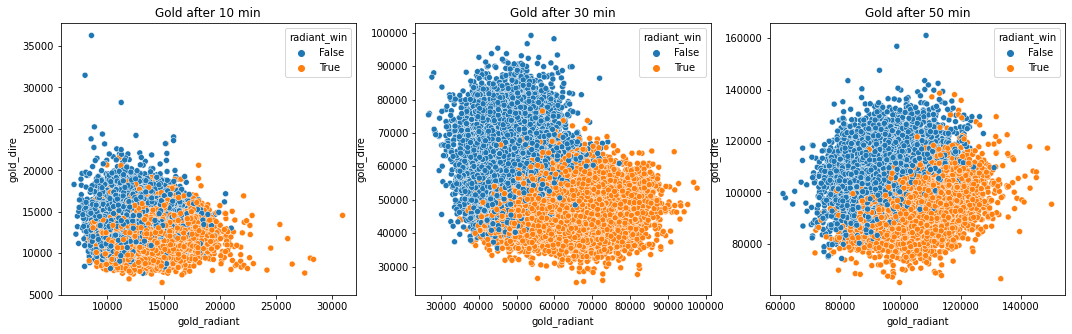

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
ax[0].set_title("Gold after 10 min")
sns.scatterplot(ax=ax[0], data=player_gold_merged[player_gold_merged['time_min'] == 10], x='gold_radiant', y='gold_dire', hue='radiant_win')
ax[1].set_title("Gold after 30 min")
sns.scatterplot(ax=ax[1], data=player_gold_merged[player_gold_merged['time_min'] == 30], x='gold_radiant', y='gold_dire', hue='radiant_win')
ax[2].set_title("Gold after 50 min")
sns.scatterplot(ax=ax[2], data=player_gold_merged[player_gold_merged['time_min'] == 50], x='gold_radiant', y='gold_dire', hue='radiant_win')

We can see in the scatter plots that there seems to be a strong correlation between the gold that a team has and its win probability.

<AxesSubplot:title={'center':'Gold lead to win percentage'}, xlabel='Time (minutes)', ylabel='Percentage'>

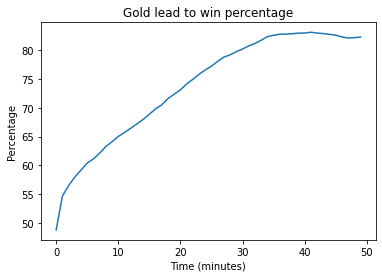

In [7]:
# Calculate correlation of win and gold lead at a specific time
def lead_to_win_percentage(time):
    data = player_gold_merged[player_gold_merged['time_min'] == time]
    return np.sum(data['radiant_lead']==data['radiant_win'])/data.shape[0]*100

lead_to_win_percent = []
for i in range(0,50):
    lead_to_win_percent.append(lead_to_win_percentage(i))

plt.title("Gold lead to win percentage")
plt.xlabel("Time (minutes)")
plt.ylabel("Percentage")
sns.lineplot(x=range(0,50), y=lead_to_win_percent)

We can see from this graph that being in the gold lead can have a strong effect on the win percentage. Just 5 minutes past the start of the game, around 60% teams in the gold lead won. At the 40 minute mark, this percentage goes up to almost 85%. We can also check what is the proportion of teams that won the match while being in the gold lead.

In [8]:
# Calculate how many teams won with a gold lead
player_gold_match_end = player_gold_merged.merge(match, on='match_id')
data = player_gold_match_end[player_gold_match_end['times']==player_gold_match_end['duration']]
percentage = np.sum(data['radiant_lead']==data['radiant_win_x'])/data.shape[0]*100
print(f"{percentage:.2f}% teams won with a gold lead at the end of the match.")

98.40% teams won with a gold lead at the end of the match.


**Training model to predict win based on gold levels**

In [12]:
# Create dataset with gold levels until a specific time
def create_dataset(game_duration):
    # Get match_id's for games that lasted atleast as long as `game_duration`
    game_duration_matches = player_gold_match_end[player_gold_match_end['duration'] > game_duration*60]['match_id'].unique()

    X = np.empty((len(game_duration_matches), 2*game_duration))
    y = np.full((len(game_duration_matches)), False)
    
    for idx, match_id in enumerate(game_duration_matches):
        data = player_gold_merged[player_gold_merged['match_id']==match_id]
        gold = np.concatenate([data['gold_radiant'].to_numpy().reshape(1, data['gold_radiant'].shape[0])[0][:game_duration],
                               data['gold_dire'].to_numpy().reshape(1, data['gold_dire'].shape[0])[0][:game_duration]])
        y[idx] = data['radiant_win'].iat[0]
        X[idx] = gold
    
    return X, y

Train a logistic regression model that predicts the win based on gold levels per team for different game durations

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from joblib import parallel_backend

score_dict = {}

for game_duration in [5,10,15,20,25,30,35,40,45,50,55,60]:
    X, y = create_dataset(game_duration)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
    clf = LogisticRegressionCV(max_iter=5000)
    with parallel_backend('threading', n_jobs=8):
        clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
    print(f"--- Game duration: {game_duration} min complete")
    score_dict[game_duration] = (train_score, test_score)

In [14]:
# Display the train and test accuracies for different durations of matches
score_dict
for key, value in score_dict.items():
    print(f"Game time: {key:02d} min | Train score: {value[0]:.3f} | Test score: {value[1]:.3f}")

Game time: 05 min | Train score: 0.595 | Test score: 0.598
Game time: 10 min | Train score: 0.641 | Test score: 0.640
Game time: 15 min | Train score: 0.684 | Test score: 0.679
Game time: 20 min | Train score: 0.725 | Test score: 0.723
Game time: 25 min | Train score: 0.766 | Test score: 0.761
Game time: 30 min | Train score: 0.783 | Test score: 0.787
Game time: 35 min | Train score: 0.798 | Test score: 0.804
Game time: 40 min | Train score: 0.796 | Test score: 0.790
Game time: 45 min | Train score: 0.776 | Test score: 0.771
Game time: 50 min | Train score: 0.757 | Test score: 0.756
Game time: 55 min | Train score: 0.733 | Test score: 0.700
Game time: 60 min | Train score: 0.688 | Test score: 0.640


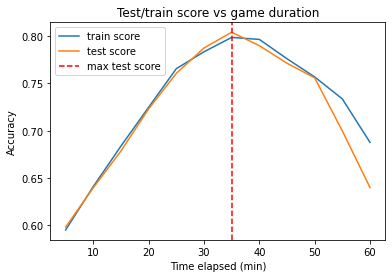

In [21]:
sns.lineplot(x=score_dict.keys(), y=[x[0] for x in score_dict.values()], label="train score")
sns.lineplot(x=score_dict.keys(), y=[x[1] for x in score_dict.values()], label="test score")
plt.axvline(x=5*(1+np.argmax([x[1] for x in score_dict.values()])), c='red', linestyle='dashed', label="max test score")
plt.title('Test/train score vs game duration')
plt.xlabel('Time elapsed (min)')
plt.ylabel('Accuracy')
plt.legend()

We can see that we get a model that predicts the win with 80% accuracy based on the gold levels of the teams just 35 minutes after game start. We can get pretty good estimates with shorted durations as well. This result also affirms the earlier observation that the gold levels stop being strong predictors as more time passes.